# Tutorial Part 17: Training a Generative Adversarial Network on MNIST


In this tutorial, we will train a Generative Adversarial Network (GAN) on the MNIST dataset.  This is a large collection of 28x28 pixel images of handwritten digits.  We will try to train a network to produce new images of handwritten digits.


## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/17_Training_a_Generative_Adversarial_Network_on_MNIST.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

To begin, let's import all the libraries we'll need and load the dataset (which comes bundled with Tensorflow).

In [1]:
import deepchem as dc
import tensorflow as tf
from deepchem.models.optimizers import ExponentialDecay
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
%matplotlib inline

mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')
images = mnist[0][0].reshape((-1, 28, 28, 1))/255
dataset = dc.data.NumpyDataset(images)

Let's view some of the images to get an idea of what they look like.

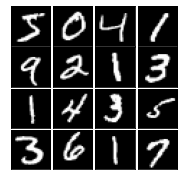

In [2]:
def plot_digits(im):
  plot.figure(figsize=(3, 3))
  grid = gridspec.GridSpec(4, 4, wspace=0.05, hspace=0.05)
  for i, g in enumerate(grid):
    ax = plot.subplot(g)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(im[i,:,:,0], cmap='gray')

plot_digits(images)

Now we can create our GAN.  Like in the last tutorial, it consists of two parts:

1. The generator takes random noise as its input and produces output that will hopefully resemble the training data.
2. The discriminator takes a set of samples as input (possibly training data, possibly created by the generator), and tries to determine which are which.

This time we will use a different style of GAN called a Wasserstein GAN (or WGAN for short).  In many cases, they are found to produce better results than conventional GANs.  The main difference between the two is in the discriminator (often called a "critic" in this context).  Instead of outputting the probability of a sample being real training data, it tries to learn how to measure the distance between the training distribution and generated distribution.  That measure can then be directly used as a loss function for training the generator.

We use a very simple model.  The generator uses a dense layer to transform the input noise into a 7x7 image with eight channels.  That is followed by two convolutional layers that upsample it first to 14x14, and finally to 28x28.

The discriminator does roughly the same thing in reverse.  Two convolutional layers downsample the image first to 14x14, then to 7x7.  A final dense layer produces a single number as output.  In the last tutorial we used a sigmoid activation to produce a number between 0 and 1 that could be interpreted as a probability.  Since this is a WGAN, we instead use a softplus activation.  It produces an unbounded positive number that can be interpreted as a distance.

In [3]:
class DigitGAN(dc.models.WGAN):

  def get_noise_input_shape(self):
    return (10,)

  def get_data_input_shapes(self):
    return [(28, 28, 1)]

  def create_generator(self):
    return tf.keras.Sequential([
        Dense(7*7*8, activation=tf.nn.relu),
        Reshape((7, 7, 8)),
        Conv2DTranspose(filters=16, kernel_size=5, strides=2, activation=tf.nn.relu, padding='same'),
        Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation=tf.sigmoid, padding='same')
    ])

  def create_discriminator(self):
    return tf.keras.Sequential([
        Conv2D(filters=32, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Conv2D(filters=64, kernel_size=5, strides=2, activation=tf.nn.leaky_relu, padding='same'),
        Dense(1, activation=tf.math.softplus)
    ])

gan = DigitGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))

Now to train it.  As in the last tutorial, we write a generator to produce data.  This time the data is coming from a dataset, which we loop over 100 times.

One other difference is worth noting.  When training a conventional GAN, it is important to keep the generator and discriminator in balance thoughout training.  If either one gets too far ahead, it becomes very difficult for the other one to learn.

WGANs do not have this problem.  In fact, the better the discriminator gets, the cleaner a signal it provides and the easier it becomes for the generator to learn.  We therefore specify `generator_steps=0.2` so that it will only take one step of training the generator for every five steps of training the discriminator.  This tends to produce faster training and better results.

In [4]:
def iterbatches(epochs):
  for i in range(epochs):
    for batch in dataset.iterbatches(batch_size=gan.batch_size):
      yield {gan.data_inputs[0]: batch[0]}

gan.fit_gan(iterbatches(100), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 4999: generator average loss 0.340072, discriminator average loss -0.0234236
Ending global_step 9999: generator average loss 0.52308, discriminator average loss -0.00702729
Ending global_step 14999: generator average loss 0.572661, discriminator average loss -0.00635684
Ending global_step 19999: generator average loss 0.560454, discriminator average loss -0.00534357
Ending global_step 24999: generator average loss 0.556055, discriminator average loss -0.00620613
Ending global_step 29999: generator average loss 0.541958, discriminator average loss -0.00734233
Ending global_step 34999: generator average loss 0.540904, discriminator average loss -0.00736641
Ending global_step 39999: generator average loss 0.524298, discriminator average loss -0.00650514
Ending global_step 44999: generator average loss 0.503931, discriminator average loss -0.00563732
Ending global_step 49999: generator average loss 0.528964, discriminator average loss -0.00590612
Ending global_step 54999

Let's generate some data and see how the results look.

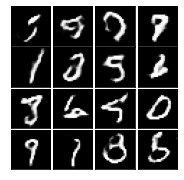

In [5]:
plot_digits(gan.predict_gan_generator(batch_size=16))

Not too bad.  Many of the generated images look plausibly like handwritten digits.  A larger model trained for a longer time can do much better, of course.

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!